In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [5]:
def rho_red_light(x, rho_max):
    """
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndaray
        Locations on the road as a 1D array of floats.
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    """
    rho = rho_max * np.ones_like(x)
    mask = np.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    return rho

In [6]:
# Set the parameters.
nx = 81 # number of locations on the road
L = 4.0 # length of the road
dx = L / (nx - 1) # distance between two consecutive locations
nt = 40 # number of time steps
rho_max = 10.0 # maximum traffic density allowed
u_max = 1.0 # maximum speed traffic

# Get the road locations.
x = np.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
rho0 = rho_red_light(x, rho_max)

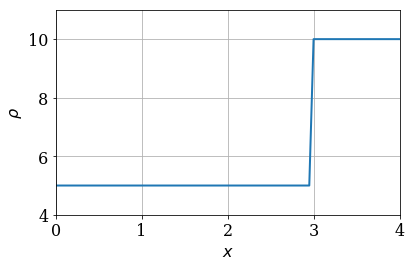

In [7]:
# Plot the initial traffic density.
fig = plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.grid()
line = plt.plot(x, rho0, 
                color='C0', linestyle='-', linewidth=2)[0]
plt.xlim(0.0, L)
plt.ylim(4.0, 11.0)
plt.tight_layout()

In [8]:
def flux(rho, u_max, rho_max):
    """
    Computes the traffic flux F = V * rho.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    rho_max : float
        Maximum car density allowed on the road.
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats.
    """
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [9]:
from matplotlib import animation
from IPython.display import HTML

In [10]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [14]:
# Lax-Friedrichs scheme.

def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using Lax-Friedrichs scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Advance in time using the Lax-Friedrichs scheme.
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) - 
                     dt / (2.0 * dx) * (F[2:] - F[:-2]))
        # Set the BC at the first location.
        rho[0] = bc_values[0]
        # Set the BC at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [15]:
# Lax-Friedrichs with CFL = 1
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [16]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [17]:
# Lax-Friedrichs with CFL = 0.5
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [18]:
# Create an animation of the tarffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [19]:
# Lax-Wendroff scheme.

In [20]:
def jacobian(rho, u_max, rho_max):
    """
    Computes the Jacobian for our traffic model
    
    Parameters
    ----------
    rho : np.ndarray
        Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    rho_max : float
        Maximum car density allowed on the road.
        
    Returns
    -------
    J : np.ndarray
        The Jacobian as a 1D array of floats.
    """
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J

In [23]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road
    at a certain time given the initial traffic density.
    Integration using Lax-Wendroff scheme.
    
    Parameters
    ----------
    rho0 : np.ndarray
        The initial traffic density along the road
        as a 1D array pf floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations.
    bc_values : 2 tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the
        flux and Jacobian functions.
        
    Returns
    -------
    rho_list : list of np.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Compute the Jacobian.
        J = jacobian(rho, *args)
        # Advance in time using the Lax-Wendroff scheme.
        rho[1:-1] = (rho[1:-1] - 
                     dt / (2.0 * dx) * (F[2:] - F[:-2]) + 
                     dt**2 / (4.0 * dx**2) *
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) - 
                       (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        # Set the BC at the first location.
        rho[0] = bc_values[0]
        # Set the BC at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [24]:
# Set the time-step size based on CFL limit = 1.0.
sigma = 1.0
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [25]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [26]:
# Set the time-step size based on CFL limit = 0.5.
sigma = 0.5
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [27]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [28]:
# MacCormack Scheme

In [32]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road
    at a certain time given the initial traffic density.
    Integration using MacCormack scheme.
    
    Parameters
    ----------
    rho0 : np.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
        
    Returns
    -------
    rho_hist : list of np.ndarray objects
        The history of the car density along the road
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Predictor step of the MacCormack scheme.
        rho_star[1:-1] = (rho[1:-1] - 
                          dt / dx * (F[2:] - F[1:-1]))
        # Compute the flux.
        F = flux(rho_star, *args)
        # Corrector step of the MacCormack scheme.
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] - 
                           dt / dx * (F[1:-1] - F[:-2]))
        # Set the BC at the first location.
        rho[0] = bc_values[0]
        # Set the BC at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [34]:
# Set the time-step size based on CFL limit = 1.0.
sigma = 1.0
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [35]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [36]:
# Set the time-step size based on CFL limit = 0.5
sigma = 0.5
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [37]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())